# Analysis of Rain on Snow Database

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from ros_database.processing.surface import read_iowa_mesonet_file, load_station_metadata
from ros_database.filepath import SURFOBS_HOURLY_PATH

## Explore total event counts

We generate a `pandasDataFrame` containing total number of events by type for each station

In [2]:
def total_events(df): 
    """Return total number of events"""
    return df[["UP", "RA", "FZRA", "SOLID"]].sum().to_dict()
    

def get_stationid(df):
    """Return station id"""
    return df.iloc[0]["station"]


indices = []
data = []
for fp in SURFOBS_HOURLY_PATH.glob("*.hourly.csv"):
    df = read_iowa_mesonet_file(fp) 
    indices.append(get_stationid(df)) 
    data.append(total_events(df))
total_events = pd.DataFrame(data, index=indices)
#total_events.index.name = 'stid'

# Generate summary columns for Rain on Snow (ROS) and Total number of events
total_events["ROS"] = total_events[["RA","FZRA"]].sum(axis=1)
total_events["Total"] = total_events.sum(axis=1)

# Get station metadata and merge coordinates with total_events
stations = load_station_metadata()
total_events = total_events.join(stations[['longitude', 'latitude']])

In [3]:
total_events.head()

,UP,RA,FZRA,SOLID,ROS,Total,longitude,latitude
BGAA,0,380,134,3817,514,4845,-52.78475,68.72185
BGBW,0,2137,40,5121,2177,9475,-45.42598,61.16052
BGCO,0,56,1,1066,57,1180,-22.65000,70.75000
BGGH,0,2393,364,12818,2757,18332,-51.67660,64.19315
BGJN,0,944,73,10715,1017,12749,-51.06611,69.24028


The total number of Rain on Snow events in the database are given below

In [4]:
total_events[["RA","FZRA"]].sum()

RA      765610
FZRA     18174
dtype: int64

## Make map of number of events

In [5]:
total_events['ROS'].median()

1961.0

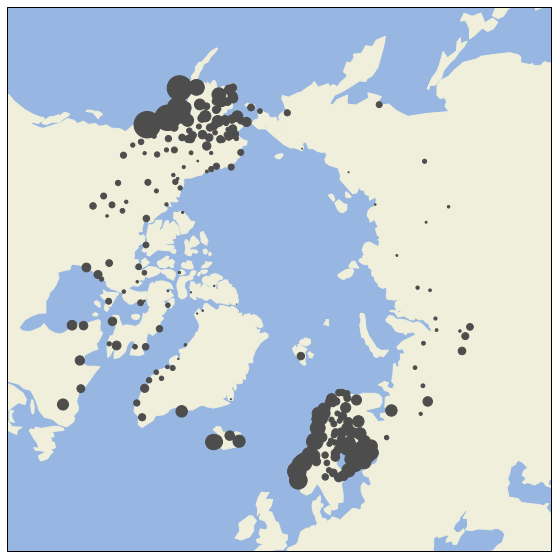

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.NorthPolarStereo())

ax.set_extent([-180., 180., 50., 90.], ccrs.PlateCarree())
#ax.coastlines()
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)


max_symbol_size = 700
symbol_color = '0.3'
symbol_size = max_symbol_size * total_events['ROS'] / total_events['ROS'].max()
xy = ax.scatter(total_events.longitude, total_events.latitude, s=symbol_size, c=symbol_color, 
               transform=ccrs.PlateCarree())

# Make the legend  This needs to be figured out
legend_sizes = max_symbol_size * np.array([30000, 10000, 1000]) / total_events['ROS'].max()
#ax.transAxes.transform((0.9, 0.9))
#ax.transData.inverted((592.2, 579.24))
#circle1 = mpatches.Circle((0.5, 0.5), radius=0.1, color=symbol_color, transform=ax.transData)
#ax.add_patch(circle1)
#ax.scatter(legend_location[0][0], legend_location[0][1], s=10, marker='+')
#ax.legend(handles=[circle1])

fig.savefig('total_events_map.png')

## Make a heat map of events by month

In [7]:
filepath = list()

In [8]:
def month_event_counts(df):
    """Returns a DataFrame containing events aggregated by month"""
    return df[['UP', 'RA', 'FZRA', 'SOLID']].resample('M').sum()

In [9]:
data = []
indices = []
for fp in SURFOBS_HOURLY_PATH.glob("*.hourly.csv"):
    df = read_iowa_mesonet_file(fp)
    indices.append(get_stationid(df))
    data.append(month_event_counts(df))
df_all = pd.concat(data, axis=1, keys=indices)

In [10]:
def get_single_ptype(df, ptype: str):
    """Extracts columns for a single precipitation type"""
    return df.xs(ptype, level=1, axis=1)

In [11]:
RA = get_single_ptype(df_all, 'RA').replace({0.: np.nan})
FZRA = get_single_ptype(df_all, 'FZRA').replace({0.: np.nan})
SOLID = get_single_ptype(df_all, 'SOLID').replace({0., np.nan})

In [12]:
def make_yticklabels(y, interval=5.):
    """Returns yticks and ylabels"""
    if y.dtype != 'float64':
        raise TypeError(f"Expects float, got {y.dtype}")
    ylabels = np.arange(y.min().round(-1), y.max().round(-1)+interval, interval)
    yticks = np.interp(ylabels, y, np.arange(len(y)))
    return yticks, ylabels

def heatmap(X, y=None, ax=None, aspect=0.4, cmap='viridis', **kwargs):
    """Plots a heat map with date labels
    
    :X: pd.DataFrame containing counts
    :y: alternative y labels, expects np.array
    """
    if ax is None:
        ax = plt.gca()
    
    x = X.index
    if y is None:
        y = X.columns
        yticks = np.arange(len(y))
        ylabels = y
    else:
        raise NotImplementedError("Alternative y-labels are not implemented yet")
        yticks, ylabels = make_yticklabels(y, interval=2.)
    data = X.T.values
    
    yticks = [0, 53,  76,  90,  94, 120, 146, 169, 244]
    ylabels = ['CA', 'FI', 'GL', 'IS', 'NO', 'RU', 'SE', 'US']
    xticks = np.where(X.index.month == 1)[0]
    xlabels = X.index.year[xticks]
    
    cmap = mcolors.ListedColormap(mpl.cm.get_cmap(cmap)(np.linspace(0.,1.,5)))
    norm = mcolors.BoundaryNorm([1.,50.,100.,150.,200.], ncolors=cmap.N, clip=False)
    im = ax.imshow(data, aspect=aspect, cmap=cmap, **kwargs, origin='upper', norm=norm)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=15)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_yticks([(yticks[i]+yticks[i+1])*0.5 for i in range(len(yticks)-1)], minor=True)
    ax.set_yticklabels(ylabels, fontsize=20, minor=True)
    
    ax.grid(axis='y', which='major', linewidth=1, color='0.2')
    
    fig.colorbar(im, shrink=0.7, pad=0.01, extend='max')

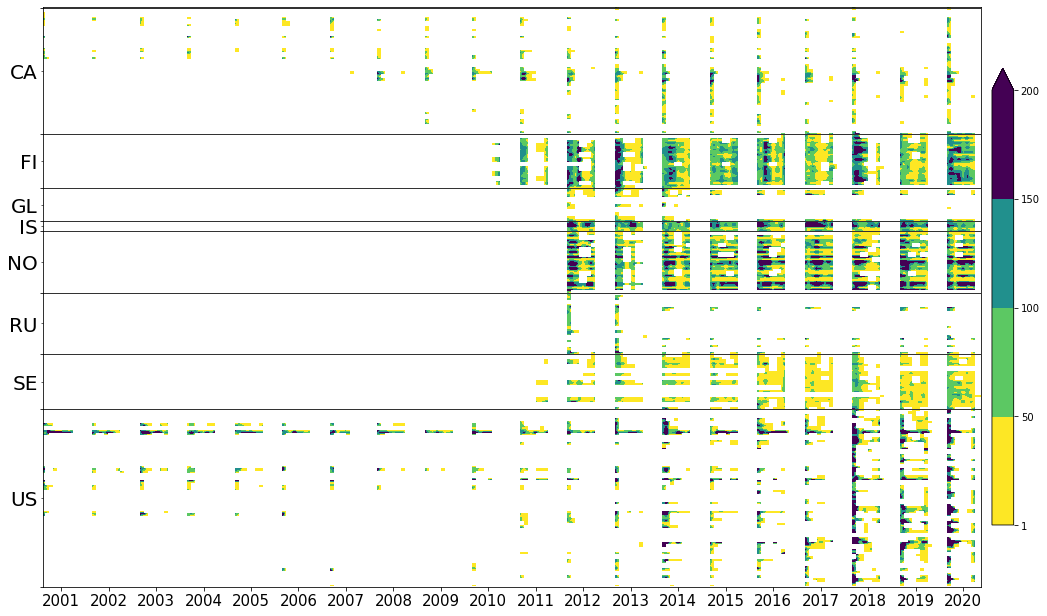

In [13]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(RA[country_order], cmap="viridis_r", aspect=ys/xs)
fig.savefig('ra_timeseries_heatmap.png')

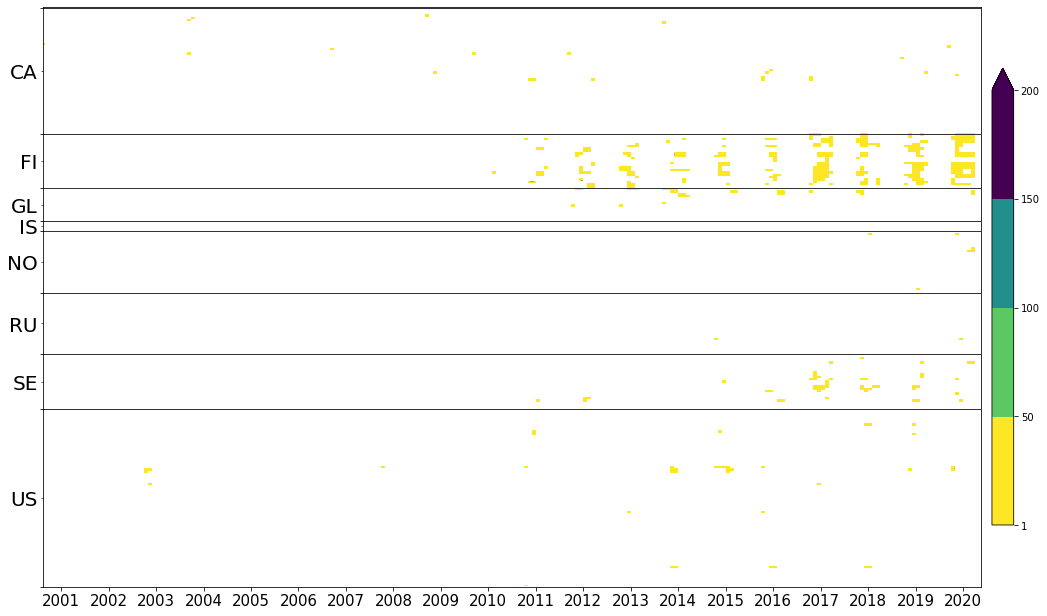

In [14]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(FZRA[country_order], cmap="viridis_r", aspect=ys/xs)

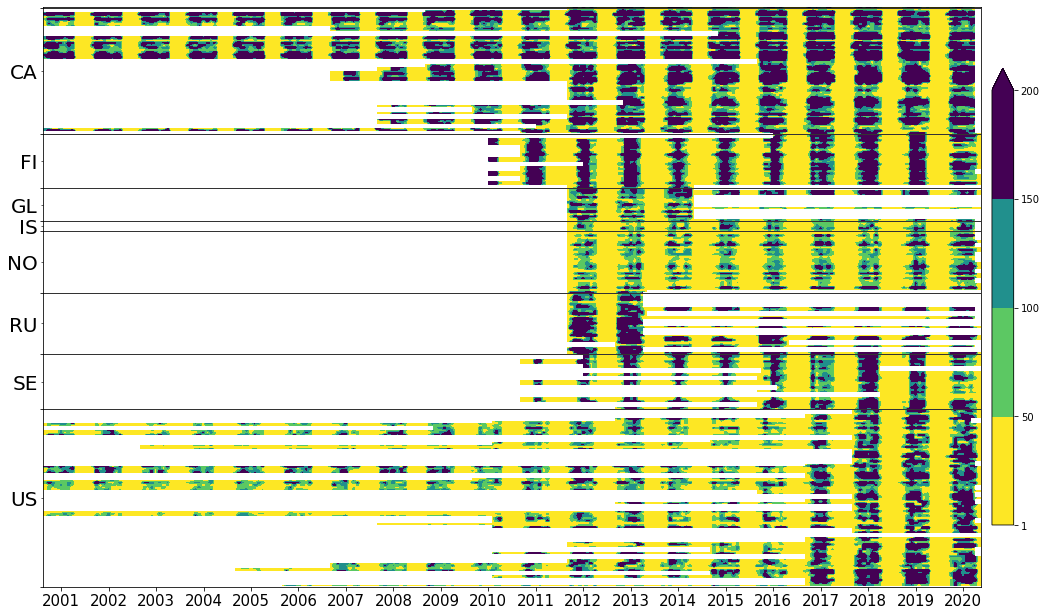

In [15]:
xs = 20
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
heatmap(SOLID[country_order], cmap="viridis_r", aspect=ys/xs)

## Plot monthly distribution of counts

In [16]:
month_counts = RA.groupby(RA.index.month).sum().replace({0.: np.nan})
month_fraction = month_counts / month_counts.sum()
month_counts

,BGAA,BGBW,BGCO,BGGH,BGJN,BGKK,BGMQ,BGPT,BGQQ,BGSF,...,USDD,USHH,USMM,USMU,USNN,USRK,USRR,UUYH,UUYS,UUYY
datetime,,,,,,,,,,,,,,,,,,,,,
1,11.0,68.0,NaN,19.0,16.0,319.0,9.0,25.0,NaN,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0
2,1.0,112.0,NaN,68.0,20.0,300.0,30.0,44.0,NaN,NaN,...,NaN,23.0,NaN,NaN,3.0,NaN,11.0,NaN,NaN,32.0
3,2.0,132.0,NaN,69.0,26.0,191.0,47.0,39.0,2.0,7.0,...,NaN,96.0,NaN,2.0,18.0,NaN,28.0,NaN,NaN,178.0
4,20.0,236.0,NaN,270.0,75.0,800.0,90.0,145.0,NaN,75.0,...,151.0,617.0,67.0,92.0,405.0,75.0,468.0,110.0,138.0,585.0
5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,221.0,834.0,48.0,1058.0,520.0,1347.0,558.0,433.0,87.0,530.0,...,287.0,954.0,166.0,169.0,912.0,83.0,972.0,276.0,180.0,1010.0


In [17]:
month_counts.max(axis=1)

datetime
1     3691.0
2     2966.0
3     2237.0
4     3565.0
5        7.0
6        NaN
7        NaN
8        NaN
9     5002.0
10    5015.0
11    4048.0
12    3859.0
dtype: float64

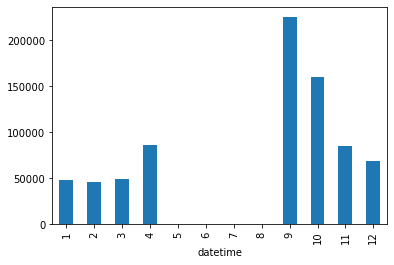

In [18]:
month_counts.sum(axis=1).plot.bar()

In [19]:
def month_heatmap(X, y=None, ax=None, aspect=0.4, cmap='viridis', **kwargs):
    """Plots a heat map with date labels
    
    :X: pd.DataFrame containing counts
    :y: alternative y labels, expects np.array
    """
    if ax is None:
        ax = plt.gca()
    
    x = X.index
    if y is None:
        y = X.columns
        yticks = np.arange(len(y))
        ylabels = y
    else:
        raise NotImplementedError("Alternative y-labels are not implemented yet")
        yticks, ylabels = make_yticklabels(y, interval=2.)
    data = X.T.values
    
    yticks = [0, 53,  76,  90,  94, 120, 146, 169, 244]
    ylabels = ['CA', 'FI', 'GL', 'IS', 'NO', 'RU', 'SE', 'US']
    xticks = np.arange(12) + 0.5
    xlabels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
    cmap = mcolors.ListedColormap(mpl.cm.get_cmap(cmap)(np.linspace(0.,1.,)))
    norm = mcolors.BoundaryNorm([1.,1000.,2000.,3000.,4000.], ncolors=cmap.N, clip=False)
    im = ax.imshow(data, aspect=aspect, cmap=cmap, norm=norm, 
                   origin='upper', extent=[0.,12.,0.,244.],
                  interpolation='none', **kwargs)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=15)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_yticks([(yticks[i]+yticks[i+1])*0.5 for i in range(len(yticks)-1)], minor=True)
    ax.set_yticklabels(ylabels, fontsize=20, minor=True)
    
    ax.grid(axis='y', which='major', linewidth=1, color='0.2')
    
    fig.colorbar(im, shrink=0.7, pad=0.01, extend='max')
    

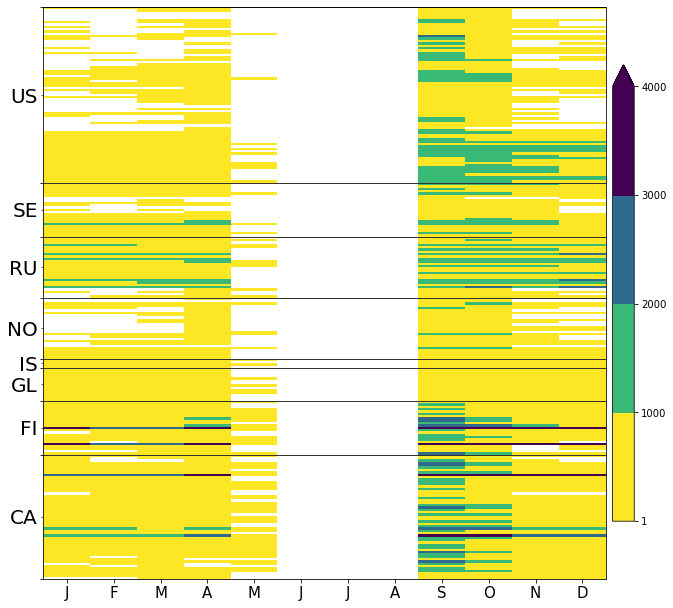

In [20]:
xs = 12
ys = 12
fig, ax = plt.subplots(figsize=(xs, ys))

country_order = stations.sort_values('country').index.values
month_heatmap(month_counts[country_order], cmap="viridis_r", aspect=0.05)

fig.savefig('month_heatmap_ra.png')

## Look at relationship between RA, FZRA and SOLID, and T2m and D2m

In [23]:
df_to_concat = []
for fp in SURFOBS_HOURLY_PATH.glob("*.hourly.csv"):
    df = read_iowa_mesonet_file(fp) 
    df_to_concat.append(df[df.RA | df.FZRA | df.SOLID].dropna(subset=['t2m', 'd2m']))
df_all = pd.concat(df_to_concat)
df_all.head()

,station,t2m,d2m,relh,mslp,psurf,p01i,UP,RA,FZRA,SOLID,wspd,drct
datetime,,,,,,,,,,,,,
2011-09-01 21:00:00,BGAA,4.5,2.0,83.86,NaN,1002.0,NaN,False,True,False,False,4.63,260.0
2011-09-02 05:00:00,BGAA,5.0,3.0,86.89,NaN,1001.5,NaN,False,True,False,False,3.59,235.0
2011-09-02 07:00:00,BGAA,5.0,4.0,93.24,NaN,1002.0,NaN,False,True,False,False,3.09,200.0
2011-09-09 00:00:00,BGAA,3.5,-0.5,75.26,NaN,990.4,NaN,False,True,False,False,3.88,302.6
2011-09-09 13:00:00,BGAA,4.0,2.0,86.79,NaN,991.9,NaN,False,True,False,False,5.66,0.0


In [24]:
len(df_all)

3177182

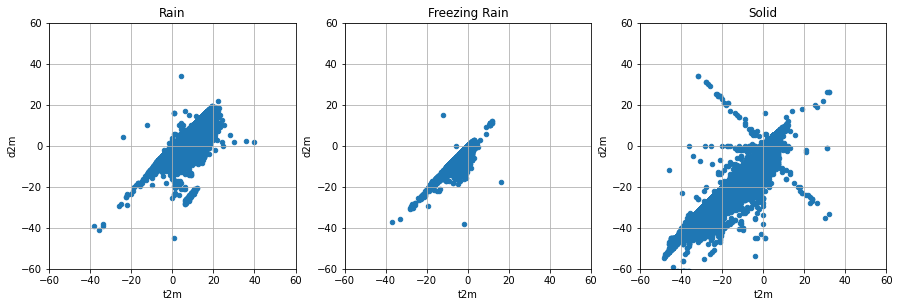

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15,9))

xlim = ylim = (-60,60)

df_all[df_all.RA].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[0], title='Rain')
ax[0].set_aspect('equal')
ax[0].grid(zorder=3)

df_all[df_all.FZRA].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[1], title='Freezing Rain')
ax[1].set_aspect('equal')
ax[1].grid(zorder=3)

df_all[df_all.SOLID].plot.scatter(x='t2m', y='d2m', xlim=xlim, ylim=ylim, ax=ax[2], title='Solid')
ax[2].set_aspect('equal')
ax[2].grid(zorder=3)


### Look at the monthly plots